In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

## Kevin

In [3]:
# Set visualization style
sns.set_palette("husl")
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

In [10]:
# Data Preprocessing
# ======================
# Load dataset
df = pd.read_csv("car_price_dataset.csv")

# Feature engineering
current_year = 2023
df['CarAge'] = current_year - df['Year']
df = df.drop(['Model'], axis=1)  # Remove high-cardinality column

# Process target variable
df['Price'] = np.log1p(df['Price'])  # Log transformation

In [5]:
# Split dataset
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Preprocessing Pipeline
numeric_features = ['Year', 'Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'CarAge']
categorical_features = ['Brand', 'Fuel_Type', 'Transmission']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [7]:
# Model Configuration
# ======================
model_config = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [200, 300],
            'model__max_depth': [15, 20, None],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [200, 300],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.05, 0.1]
        }
    }
}


Training RandomForest


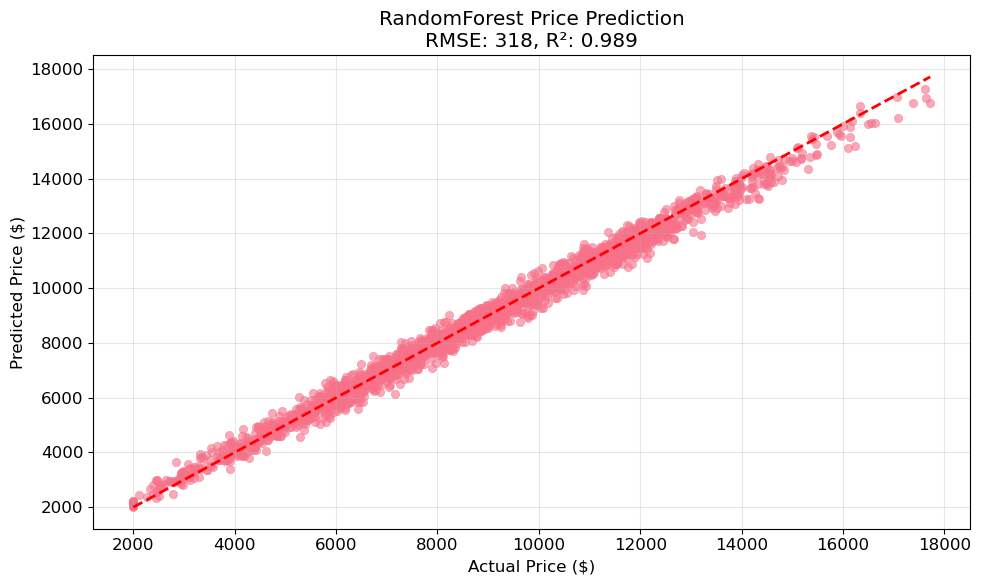

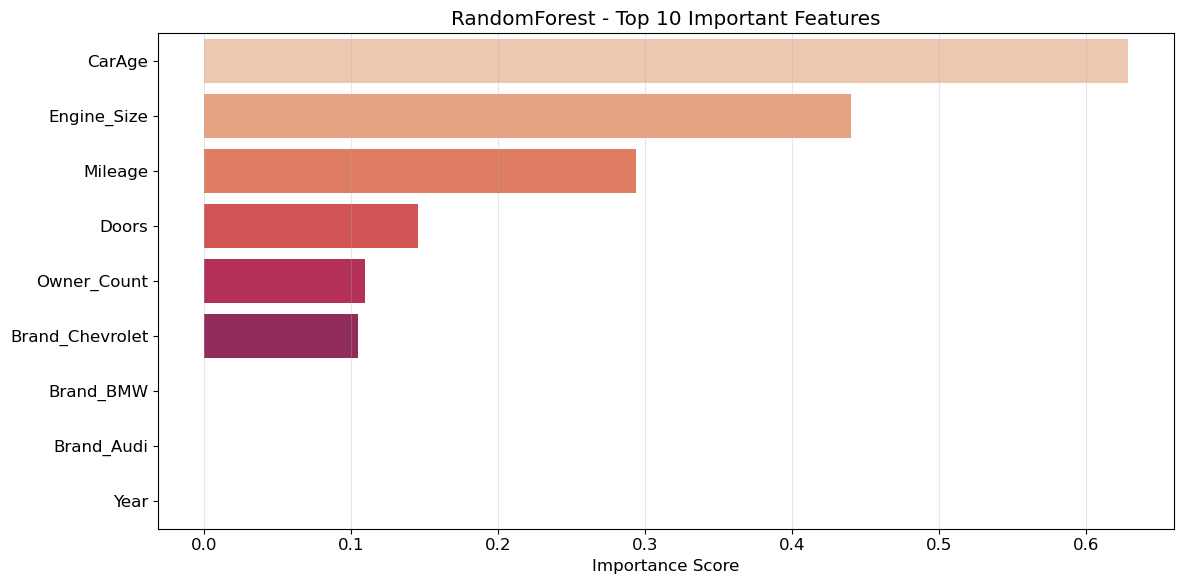


Training GradientBoosting


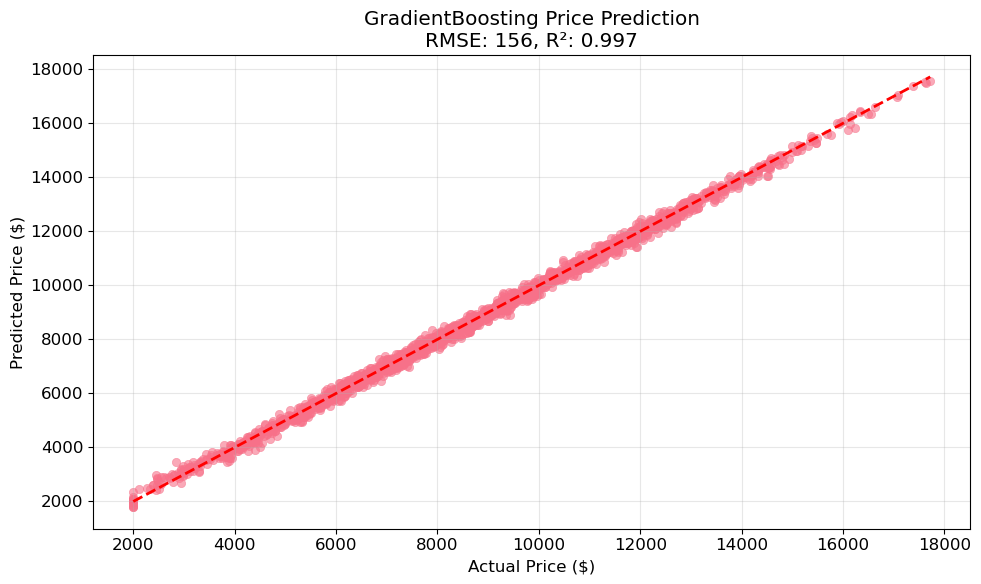

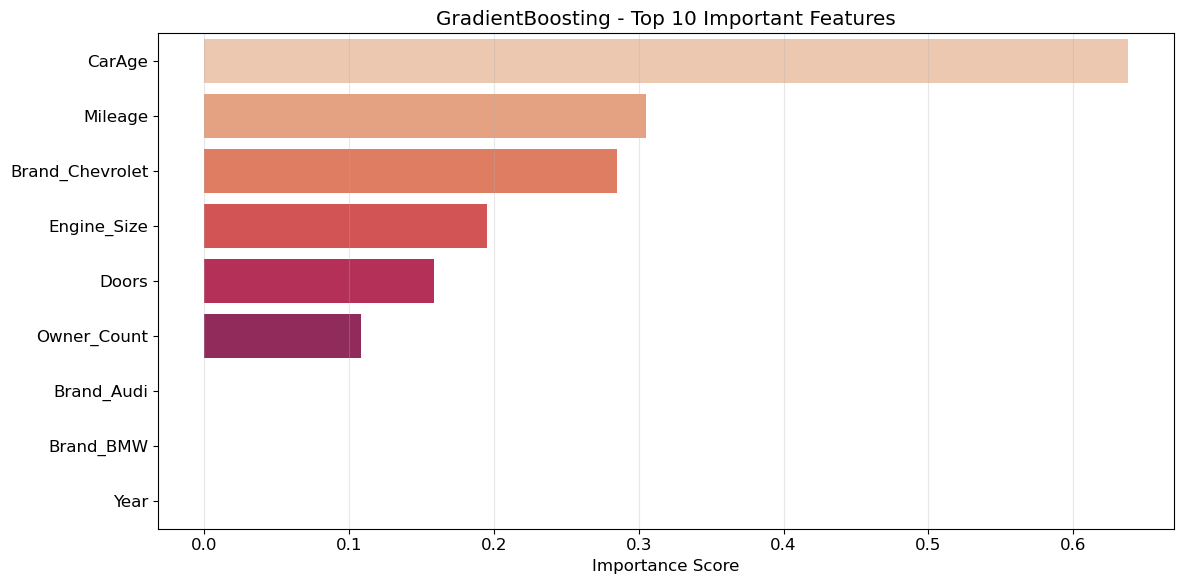

In [8]:
# Training and Evaluation
# ======================
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, edgecolor=None)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title(f'{model_name} Price Prediction\nRMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.0f}, R²: {r2_score(y_true, y_pred):.3f}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importances, feature_names, model_name, top_n=10):
    sorted_idx = importances.argsort()[::-1][:top_n]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[sorted_idx], y=np.array(feature_names)[sorted_idx], palette="rocket_r")
    plt.title(f'{model_name} - Top {top_n} Important Features')
    plt.xlabel('Importance Score')
    plt.ylabel('')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

results = []
feature_importances = {}

for model_name, config in model_config.items():
    print(f"\n{'='*30}")
    print(f"Training {model_name}")
    print(f"{'='*30}")
    
    # Build Pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])
    
    # Grid Search
    grid = GridSearchCV(
        pipe,
        param_grid=config['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    # Get best model
    best_model = grid.best_estimator_
    
    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    
    # Reverse target variable transformation
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    r2 = r2_score(y_test_exp, y_pred_exp)
    
    # Save results
    results.append({
        'Model': model_name,
        'Best Params': str(grid.best_params_),
        'RMSE': rmse,
        'R²': r2
    })
     # Compute feature importance
    trained_preprocessor = best_model.named_steps['preprocessor']
    numeric_features = trained_preprocessor.transformers_[0][2]
    categorical_features = trained_preprocessor.transformers_[1][2]
    ohe = trained_preprocessor.named_transformers_['cat']
    encoded_cat_features = ohe.get_feature_names_out(categorical_features)
    feature_names = numeric_features + list(encoded_cat_features)
    
    result = permutation_importance(
        best_model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42
    )
    
    feature_importances[model_name] = {
        'importances': result.importances_mean,
        'feature_names': feature_names
    }
    # Generate visualizations
    plot_actual_vs_predicted(y_test_exp, y_pred_exp, model_name)
    plot_feature_importance(result.importances_mean, feature_names, model_name)



Final Results:
              Model        RMSE        R²
0      RandomForest  317.528849  0.989026
1  GradientBoosting  156.281898  0.997342


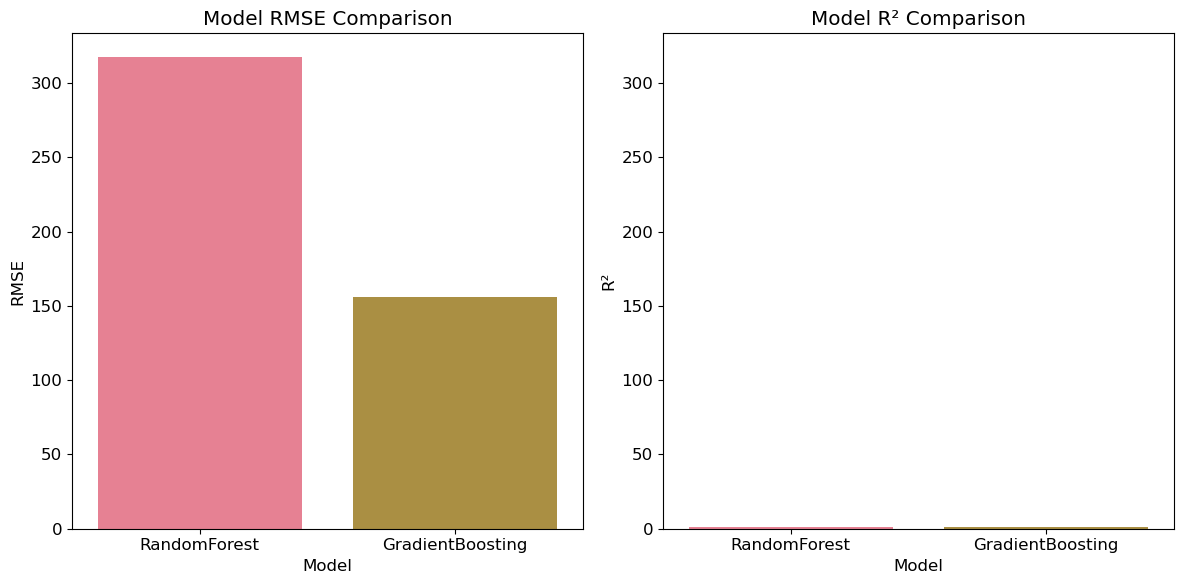

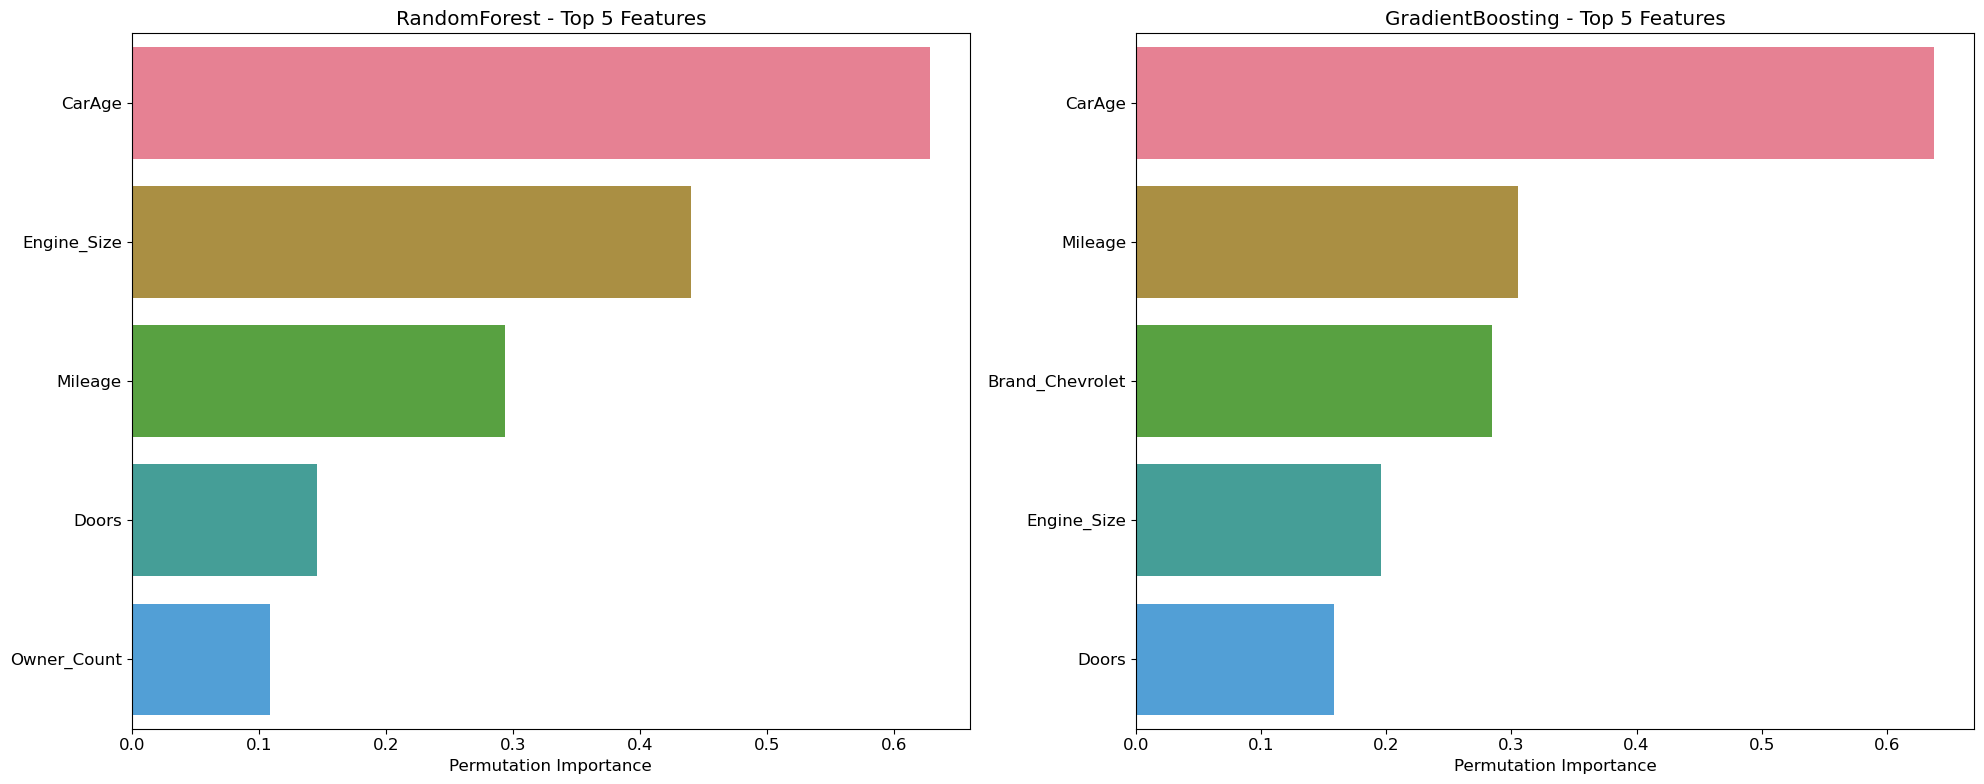

In [9]:
# Compare results
results_df = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df[['Model', 'RMSE', 'R²']])

# Model performance comparison plot
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('Model RMSE Comparison')

plt.subplot(1, 2, 2, sharey=ax)
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('Model R² Comparison')
plt.tight_layout()
plt.show()

# Feature importance comparison plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, (model_name, data) in enumerate(feature_importances.items()):
    sorted_idx = data['importances'].argsort()[::-1][:5]
    sns.barplot(x=data['importances'][sorted_idx], 
                y=np.array(data['feature_names'])[sorted_idx], 
                ax=axes[idx])
    axes[idx].set_title(f'{model_name} - Top 5 Features')
    axes[idx].set_xlabel('Permutation Importance')

plt.tight_layout()
plt.show()

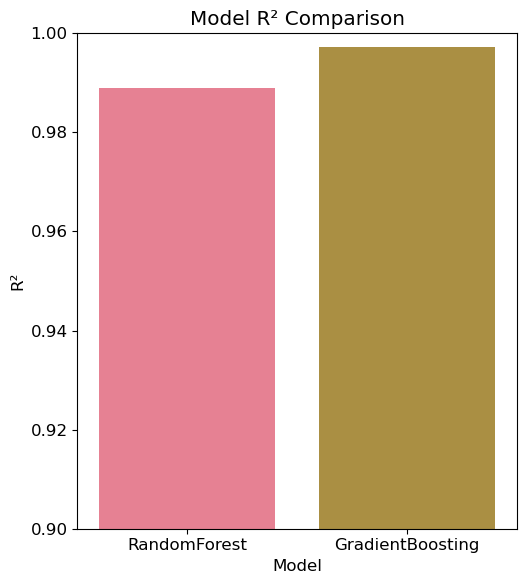

In [10]:
plt.subplot(1, 2, 2, sharey=ax)
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('Model R² Comparison')
plt.ylim(0.9, 1)  
plt.tight_layout()
plt.show() 

## Alvaro

In [6]:
df2 = pd.read_csv("car_price_dataset.csv")

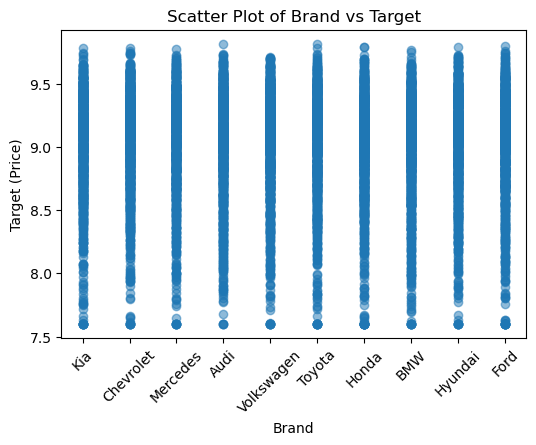

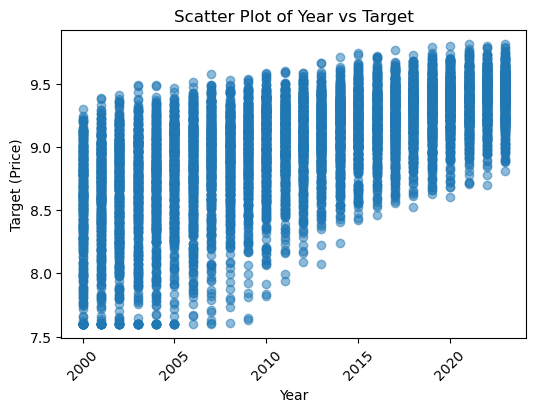

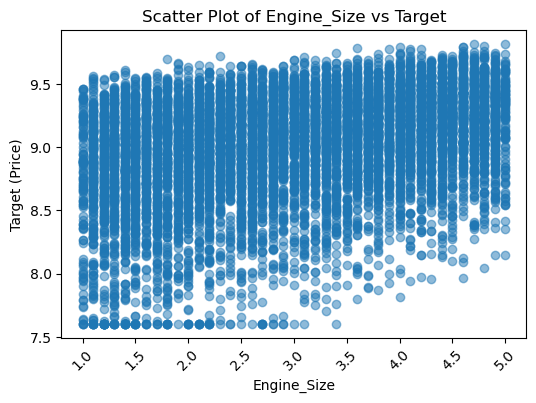

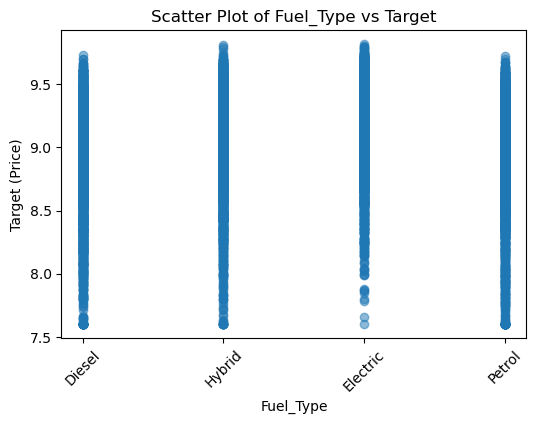

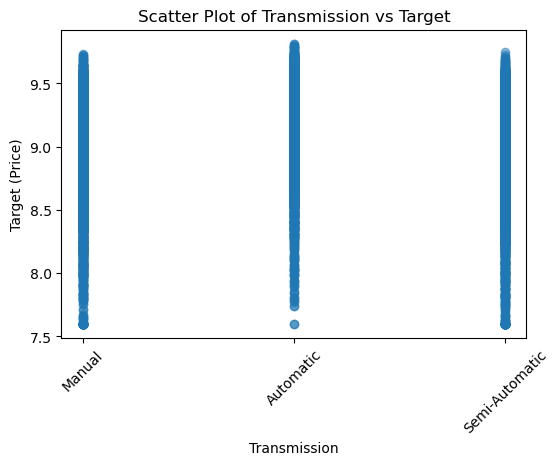

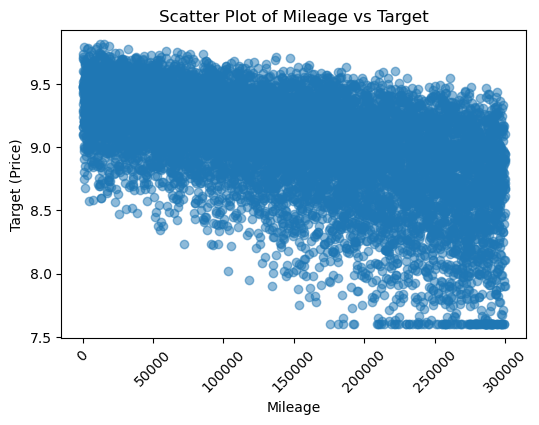

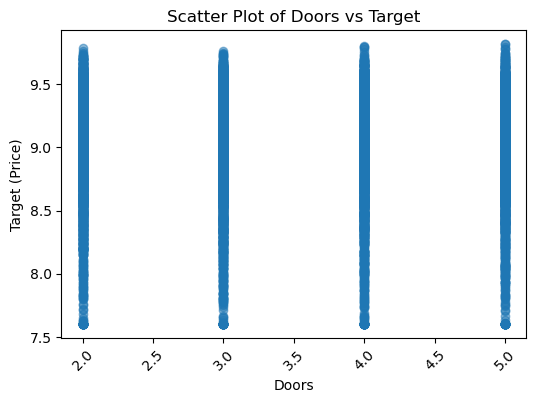

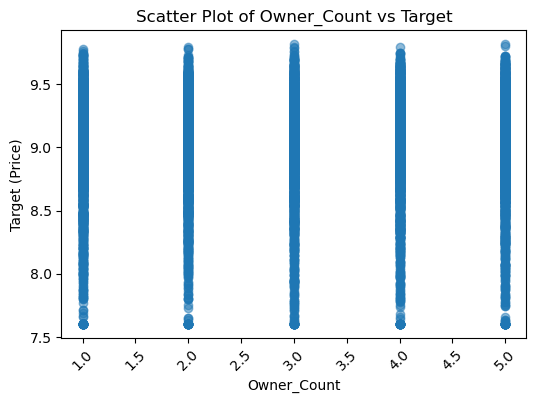

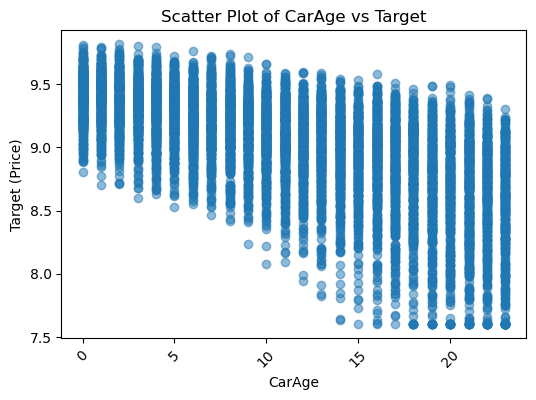

In [14]:
X_2 = df.drop('Price', axis=1)
y_2 = df['Price']

for column in X_2.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(X_2[column], y_2, alpha=0.5)
    plt.xticks(rotation=45)
    plt.xlabel(column)
    plt.ylabel('Target (Price)')
    plt.title(f'Scatter Plot of {column} vs Target')
    plt.show()

#we can see that the relationship is linear in some cases, going to use svm model

In [16]:
X_2 = pd.get_dummies(X_2, drop_first=True)

In [18]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

encoded_columns = X_train2.columns  # Assuming X_train was a DataFrame after encoding

In [48]:
scaler = StandardScaler()
#target_scaler = StandardScaler()
#target_scaler.fit(y_train.values.reshape(-1, 1))
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)


In [50]:
from sklearn.svm import SVR

model2 = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1)
model2.fit(X_train2, y_train2)

#kernel='rbf': Radial Basis Function kernel for non-linear regression.
#C: Regularization parameter. Higher values mean less regularization.
#gamma: Kernel coefficient for RBF. Affects how far influence of a single data point reaches.
#epsilon: Defines a margin of tolerance for the prediction.

SVR(C=100, gamma=0.01)

In [52]:
y_pred2 = model2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
r2_2 = r2_score(y_test2, y_pred2)

print(f"Mean Squared Error (MSE): {mse2}")
print(f"R² Score: {r2_2}")

Mean Squared Error (MSE): 0.0032589411844077894
R² Score: 0.9792296901576862


In [19]:
param_grid2 = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.1, 0.2, 0.5]
}

grid_search2 = GridSearchCV(SVR(kernel='rbf'), param_grid2, cv=3, scoring='r2')
grid_search2.fit(X_train2, y_train2)

print("Best parameters:", grid_search2.best_params_)

Best parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 0.01}


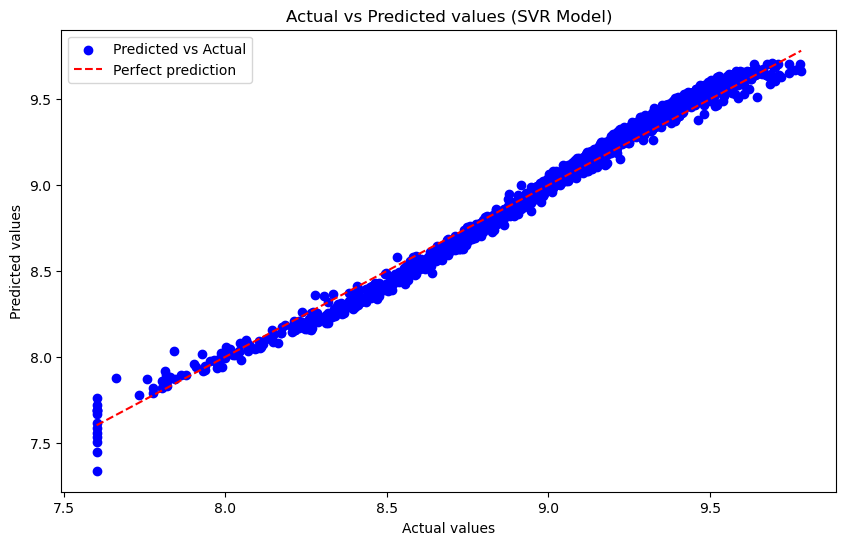

In [62]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test2, y_pred2, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test2), max(y_test2)], [min(y_test2), max(y_test2)], color='red', linestyle='--', label='Perfect prediction')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (SVR Model)')
plt.legend()
plt.show()
